In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the BF data

In [3]:
bf_path = '/content/drive/MyDrive/ALL_CLEAN_DEIDEN_NAME AND ECMO DATA(Sheet1) (1) (version 2).csv'
cols = ['ID','weight', 'study_height', 'age_days', 'bsa', 'Reason for ECMO']
df = pd.read_csv(bf_path, usecols=cols)

for col in ['weight', 'study_height', 'age_days', 'bsa']:
    s = pd.to_numeric(df[col], errors='coerce')
    mx = s.max(skipna=True)
    if pd.notna(mx) and mx != 0:
        df[col] = s / mx
    else:
        df[col] = s
print(df.head())

   ID  age_days    weight  study_height       bsa Reason for ECMO
0   1  0.018213  0.042214      0.344538  0.128389        cardiac 
1   2  0.072852  0.070000      0.431373  0.184992        cardiac 
2   3  0.793776  0.403571      0.896359  0.640295         cardiac
3   4  0.000287  0.022786      0.268908  0.083332         cardiac
4   5  0.000287  0.023571      0.285714  0.087365     respiratory


In [4]:
diag_clean = (
    df['Reason for ECMO']
      .astype('string')
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .fillna('Unknown')
)

codes, uniques = pd.factorize(diag_clean, sort=True)
df['Reason for ECMO'] = codes.astype('int64')
diagnosis_mapping = {cat: int(i) for i, cat in enumerate(uniques)}

# Peek
print(df.head())

   ID  age_days    weight  study_height       bsa  Reason for ECMO
0   1  0.018213  0.042214      0.344538  0.128389                2
1   2  0.072852  0.070000      0.431373  0.184992                2
2   3  0.793776  0.403571      0.896359  0.640295                2
3   4  0.000287  0.022786      0.268908  0.083332                2
4   5  0.000287  0.023571      0.285714  0.087365                3


In [5]:
df.shape

(73, 6)

In [6]:
df.head()

,ID,age_days,weight,study_height,bsa,Reason for ECMO
0,1,0.018213,0.042214,0.344538,0.128389,2
1,2,0.072852,0.070000,0.431373,0.184992,2
2,3,0.793776,0.403571,0.896359,0.640295,2
3,4,0.000287,0.022786,0.268908,0.083332,2
4,5,0.000287,0.023571,0.285714,0.087365,3


### No normalization!

In [8]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_nozero_181920212223_1800"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 3
EPOCHS           = 100
LR               = 1e-4
SEED             = 110
K_FOLDS          = 10

# (kept for reference; not used to fix height)
TARGET_H = 400

# =========================
# Noise config (train-time augmentation only, EEG input only)
# =========================
TRAIN_ADD_GAUSS_NOISE = True
TRAIN_NOISE_FRAC      = 0.0
TRAIN_NOISE_PROB      = 1.0
EPS_STD               = 1e-8

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# =========================
# Helpers
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')          # e.g., "ID76-2_..." -> 76
def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def label_for_id(pid: int) -> int:
    return 1 if pid in POS_PATIENTS else 0

def label_for_file(p: Path) -> int:
    pid = patient_num_from_path(p)
    return label_for_id(pid) if pid is not None else 0

# =========================
# Load your existing 3-feature DataFrame: must exist as `df`
# Columns: 'ID' + exactly 3 feature columns
# =========================
feats_df = df.copy()
if "ID" not in feats_df.columns:
    raise RuntimeError("Your features DataFrame must contain column 'ID'.")

FEAT_COLS = [c for c in feats_df.columns if c != "ID"]
#if len(FEAT_COLS) != 3:
#    raise RuntimeError(f"Expected exactly 3 feature columns besides 'ID', found {len(FEAT_COLS)}: {FEAT_COLS}")

# Clean and index by ID; drop rows with missing any of the 3 features
feats_df["ID"] = pd.to_numeric(feats_df["ID"], errors="coerce").astype("Int64")
feats_df = feats_df.dropna(subset=["ID"] + FEAT_COLS).copy()
feats_df["ID"] = feats_df["ID"].astype(int)
ID_TO_FEAT = {
    int(row["ID"]): row[FEAT_COLS].astype("float32").to_numpy()
    for _, row in feats_df.iterrows()
}
FEAT_DIM = len(FEAT_COLS)
print("FEAT_DIM =", FEAT_DIM)

# =========================
# Enumerate EEG files and keep only IDs present in features
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    if pid in ID_TO_FEAT:  # keep only IDs with features
        id_to_files.setdefault(pid, []).append(f)

valid_ids = sorted(id_to_files.keys())
y_ids = np.array([label_for_id(pid) for pid in valid_ids], dtype=int)
print("Total valid IDs:", len(valid_ids), "| Pos:", y_ids.sum(), "| Neg:", (1-y_ids).sum())

# =========================
# Utilities for loading & shaping EEG (de-dup consecutive rows)
# =========================
import pandas as pd
import numpy as np

def _drop_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    time_like = [c for c in df.columns if isinstance(c, str) and c.strip().lower() == "time"]
    return df.drop(columns=time_like, errors="ignore")

def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df = _drop_time_cols(df)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _dedupe_consecutive_rows(mat: np.ndarray) -> np.ndarray:
    if mat.size == 0:
        return mat
    if mat.ndim == 1:
        mat = mat[:, None]
    if mat.shape[0] == 1:
        return mat
    diffs = np.any(mat[1:] != mat[:-1], axis=1)
    keep = np.concatenate(([True], diffs))
    return mat[keep]

def _infer_target_width(example_csv: Path) -> int:
    df = pd.read_csv(example_csv)
    df2 = _to_numeric_df(df)
    return df2.shape[1]

# Width is fixed by columns in first sample
TARGET_W = _infer_target_width(id_to_files[valid_ids[0]][0])
print(f"TARGET_W={TARGET_W} (non-Time columns)")

# Height: max de-dup length across ALL eligible files (fixed for all folds)
def _dedup_len_from_csv(p: Path) -> int:
    df = pd.read_csv(p)
    mat = _to_numeric_df(df).to_numpy(dtype=np.float32)
    mat_d = _dedupe_consecutive_rows(mat)
    return int(mat_d.shape[0])

ALL_ELIGIBLE_FILES = [f for pid in valid_ids for f in id_to_files[pid]]
TARGET_H_DEDUP = max(_dedup_len_from_csv(f) for f in ALL_ELIGIBLE_FILES)
if TARGET_H_DEDUP <= 0:
    raise RuntimeError("After de-dup, zero-length found in data.")
print(f"Fixed input height after de-dup (all IDs): H={TARGET_H_DEDUP}")

def load_csv_as_image_dedup(csv_path: Path) -> np.ndarray:
    df  = pd.read_csv(csv_path)
    df2 = _to_numeric_df(df)
    mat = df2.to_numpy(dtype=np.float32)
    if mat.ndim != 2:
        mat = mat.reshape(mat.shape[0], -1) if mat.ndim > 2 else mat
    mat = _dedupe_consecutive_rows(mat)
    if mat.shape[0] == 0:
        mat = np.zeros((1, TARGET_W), dtype=np.float32)
    mat = _pad_crop_2d(mat, TARGET_H_DEDUP, TARGET_W)
    img = np.expand_dims(mat, axis=-1).astype(np.float32)  # (H, W, 1)
    if img.shape != (TARGET_H_DEDUP, TARGET_W, 1):
        raise ValueError(f"loader produced {img.shape}, expected {(TARGET_H_DEDUP, TARGET_W, 1)}")
    return img

CACHE_DEDUP = {}
def load_csv_as_image_cached(csv_path: Path) -> np.ndarray:
    key = str(csv_path)
    if key in CACHE_DEDUP:
        return CACHE_DEDUP[key]
    img = load_csv_as_image_dedup(csv_path)
    CACHE_DEDUP[key] = img
    return img

# =========================
# Keras Sequence — returns ({"eeg_input": X_img, "tab_input": X_tab}, y)
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True,
                 add_noise=False, noise_frac=TRAIN_NOISE_FRAC, noise_prob=TRAIN_NOISE_PROB):
        super().__init__()
        # keep only files whose patient ID has features (already ensured by id_to_files)
        self.files = list(files)
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.add_noise = add_noise
        self.noise_frac = float(noise_frac)
        self.noise_prob = float(noise_prob)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        B = len(batch_files)

        X_img = np.empty((B, TARGET_H_DEDUP, TARGET_W, 1), dtype=np.float32)
        X_tab = np.empty((B, FEAT_DIM), dtype=np.float32)
        y     = np.empty((B,), dtype=np.int32)

        for i, f in enumerate(batch_files):
            xi = load_csv_as_image_cached(f)
            if xi.ndim == 2:
                xi = xi[..., None]
            if xi.shape != (TARGET_H_DEDUP, TARGET_W, 1):
                raise ValueError(f"Sample shape {xi.shape} for {f}")
            X_img[i] = xi
            pid = patient_num_from_path(f)
            X_tab[i] = ID_TO_FEAT[pid]
            y[i] = label_for_file(f)

        # Gaussian noise on EEG only (train)
        if self.add_noise and self.noise_frac > 0.0 and self.noise_prob > 0.0:
            samp_std = X_img.reshape(B, -1).std(axis=1).astype(np.float32)
            samp_std = np.maximum(samp_std, EPS_STD).reshape(B, 1, 1, 1)
            noise = np.random.normal(0.0, 1.0, size=X_img.shape).astype(np.float32)
            noise *= (self.noise_frac * samp_std)
            if self.noise_prob < 1.0:
                mask = (np.random.rand(B, 1, 1, 1) < self.noise_prob).astype(np.float32)
                noise *= mask
            X_img = X_img + noise

        return {"eeg_input": X_img, "tab_input": X_tab}, y

# =========================
# Two-input Model: CNN (EEG) + MLP (3 features: 3 -> 8 -> 8)
# =========================
def build_model(h=TARGET_H_DEDUP, w=TARGET_W, c=1, lr=LR,
                growth_rate=4, block_layers=(2,2,2,2),
                compression=0.5, dropout=0.2, tab_dim=FEAT_DIM):

    eeg_in = keras.Input(shape=(h, w, c), name="eeg_input")

    def bn_relu_conv(x, filters, ksize, stride=1):
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(eeg_in)
    x = layers.ReLU()(x)
    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)
    x = layers.GlobalAveragePooling2D()(x)  # (B, F_eeg)

    tab_in = keras.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(8, activation="relu")(tab_in)
    t = layers.Dense(8, activation="relu")(t)

    z = layers.Concatenate()([x, t])
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(dropout)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model(inputs=[eeg_in, tab_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),
                 keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Build folds by ID (stratified)
# =========================
valid_ids_arr = np.array(valid_ids)
labels_arr = np.array([label_for_id(pid) for pid in valid_ids_arr], dtype=int)

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
fold_aucs = []

print("\n=== 10-Fold CV (by patient ID) ===")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(valid_ids_arr, labels_arr), start=1):
    train_ids = set(valid_ids_arr[train_idx].tolist())
    val_ids   = set(valid_ids_arr[val_idx].tolist())

    # list files for this fold
    train_files = [f for pid in train_ids for f in id_to_files[pid]]
    val_files   = [f for pid in val_ids   for f in id_to_files[pid]]

    # Generators
    train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True,
                              add_noise=TRAIN_ADD_GAUSS_NOISE)
    val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False,
                              add_noise=False)

    # Model & training
    model = build_model()
    ckpt_path = f"best_fold_{fold_idx:02d}.h5"
    ckpt = keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_loss", mode="min", save_best_only=True, verbose=0
    )
    hist = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=0,
    )

    # Load best and evaluate AUC on this fold's validation files
    best_model = keras.models.load_model(ckpt_path)
    # predictions
    probs = best_model.predict(val_gen, verbose=0).ravel().astype(float)
    # true labels align with val_gen.files order
    y_true = np.array([label_for_file(f) for f in val_gen.files], dtype=int)

    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')

    fold_aucs.append(auc)
    print(f"Fold {fold_idx:2d} | IDs val={len(val_ids):3d} | files val={len(val_files):4d} | AUC={auc:.4f}")

# =========================
# Results across folds
# =========================
print("\nPer-fold AUCs:")
for i, a in enumerate(fold_aucs, start=1):
    if np.isnan(a):
        print(f"  Fold {i:2d}: NaN")
    else:
        print(f"  Fold {i:2d}: {a:.4f}")

valid_aucs = [a for a in fold_aucs if not np.isnan(a)]
print("\nAUCs list:", fold_aucs)
if valid_aucs:
    print(f"Mean AUC: {np.mean(valid_aucs):.4f} ± {np.std(valid_aucs):.4f}")
    print(f"Min/Max AUC: {np.min(valid_aucs):.4f} / {np.max(valid_aucs):.4f}")
else:
    print("All AUCs are NaN; cannot compute summary statistics.")


FEAT_DIM = 5
Total valid IDs: 44 | Pos: 14 | Neg: 30
TARGET_W=6 (non-Time columns)
Fixed input height after de-dup (all IDs): H=360

=== 10-Fold CV (by patient ID) ===


Fold  1 | IDs val=  5 | files val= 215 | AUC=0.0075


Fold  2 | IDs val=  5 | files val= 170 | AUC=1.0000


Fold  3 | IDs val=  5 | files val=  69 | AUC=0.6829


Fold  4 | IDs val=  5 | files val= 168 | AUC=0.6306


Fold  5 | IDs val=  4 | files val=  84 | AUC=0.9399


Fold  6 | IDs val=  4 | files val= 146 | AUC=0.5644


Fold  7 | IDs val=  4 | files val=  50 | AUC=1.0000


Fold  8 | IDs val=  4 | files val=  37 | AUC=0.5312


Fold  9 | IDs val=  4 | files val= 239 | AUC=0.1298


Fold 10 | IDs val=  4 | files val=  22 | AUC=0.8571

Per-fold AUCs:
  Fold  1: 0.0075
  Fold  2: 1.0000
  Fold  3: 0.6829
  Fold  4: 0.6306
  Fold  5: 0.9399
  Fold  6: 0.5644
  Fold  7: 1.0000
  Fold  8: 0.5312
  Fold  9: 0.1298
  Fold 10: 0.8571

AUCs list: [np.float64(0.007484483388097847), np.float64(1.0), np.float64(0.6829059829059829), np.float64(0.6305778032036613), np.float64(0.9399313501144164), np.float64(0.5644426025694156), np.float64(1.0), np.float64(0.53125), np.float64(0.12978723404255316), np.float64(0.8571428571428572)]
Mean AUC: 0.6344 ± 0.3280
Min/Max AUC: 0.0075 / 1.0000


In [10]:
# =========================
# Results across folds
# =========================
print("\nPer-fold AUCs:")
for i, a in enumerate(fold_aucs, start=1):
    if np.isnan(a):
        print(f"  Fold {i:2d}: NaN")
    else:
        print(f"  Fold {i:2d}: {a:.4f}")

print("\nAUCs list:", fold_aucs)

valid_aucs = [a for a in fold_aucs if not np.isnan(a)]
if valid_aucs:
    print(f"Mean AUC: {np.mean(valid_aucs):.4f} ± {np.std(valid_aucs):.4f}")
    print(f"Min/Max AUC: {np.min(valid_aucs):.4f} / {np.max(valid_aucs):.4f}")
else:
    print("All AUCs are NaN; cannot compute summary statistics.")



Per-fold AUCs:
  Fold  1: 0.0075
  Fold  2: 1.0000
  Fold  3: 0.6829
  Fold  4: 0.6306
  Fold  5: 0.9399
  Fold  6: 0.5644
  Fold  7: 1.0000
  Fold  8: 0.5312
  Fold  9: 0.1298
  Fold 10: 0.8571

AUCs list: [np.float64(0.007484483388097847), np.float64(1.0), np.float64(0.6829059829059829), np.float64(0.6305778032036613), np.float64(0.9399313501144164), np.float64(0.5644426025694156), np.float64(1.0), np.float64(0.53125), np.float64(0.12978723404255316), np.float64(0.8571428571428572)]
Mean AUC: 0.6344 ± 0.3280
Min/Max AUC: 0.0075 / 1.0000


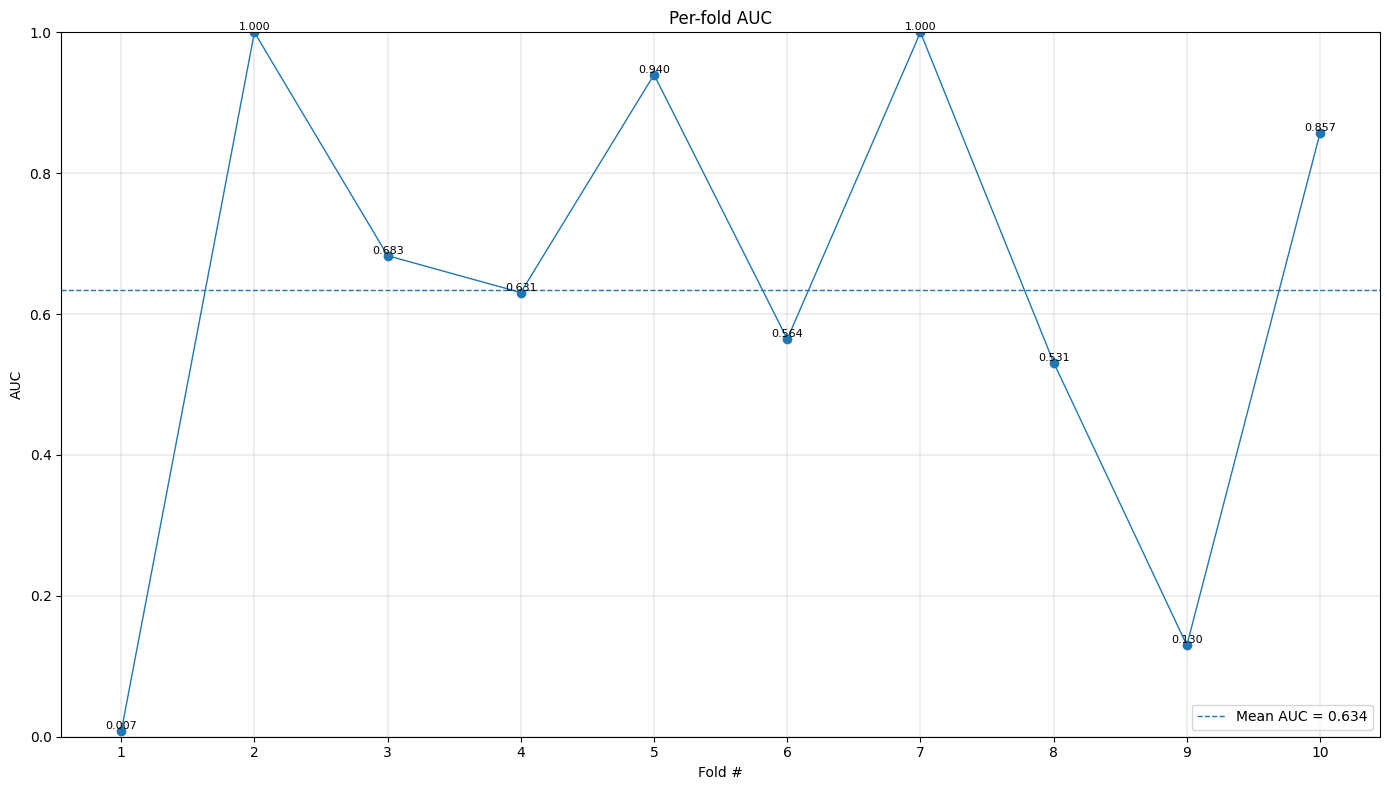

In [11]:
# === Plot per-fold AUCs ===
import matplotlib.pyplot as plt
import numpy as np

fold_indices = np.arange(1, len(fold_aucs) + 1, dtype=int)
auc_array = np.array(fold_aucs, dtype=float)

plt.figure(figsize=(14, 8))
# line+markers; NaNs will break the line, which is fine
plt.plot(fold_indices, auc_array, marker="o", linewidth=1)

# annotate non-NaN points with their values
for i, a in enumerate(auc_array, start=1):
    if not np.isnan(a):
        plt.text(i, a, f"{a:.3f}", ha="center", va="bottom", fontsize=8)

# draw mean AUC if available
valid_mask = ~np.isnan(auc_array)
if valid_mask.any():
    mean_auc = auc_array[valid_mask].mean()
    plt.axhline(mean_auc, linestyle="--", linewidth=1, label=f"Mean AUC = {mean_auc:.3f}")

plt.title("Per-fold AUC")
plt.xlabel("Fold #")
plt.ylabel("AUC")
plt.xticks(fold_indices)
plt.ylim(0.0, 1.0)
plt.grid(True, linewidth=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()